In [1]:
#!pip install lda
import pandas as pd
import lda
import numpy as np
import nltk
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

#nltk.download('stopwords')
#nltk.download('wordnet')

In [2]:
worst = pd.read_csv('Worst_20_Action_Clean.csv')
best = pd.read_csv('Top_20_Action_Clean.csv')
worst = worst.drop(columns=['Unnamed: 0'])
best = best.drop(columns=['Unnamed: 0'])
worst['best'] = 0
best['best'] = 1
df = best.append(worst, ignore_index=True)
df

,movie_name,movie_rating,movie_director,user_comment,best
0,The Dark Knight (2008),9.0,Christopher Nolan,"Confidently directed, dark, brooding, and pack...",1
1,The Dark Knight (2008),9.0,Christopher Nolan,We've been subjected to enormous amounts of hy...,1
2,The Dark Knight (2008),9.0,Christopher Nolan,It is just what you want for the best movie. G...,1
3,The Dark Knight (2008),9.0,Christopher Nolan,"I couldn't believe ""The Dark knight"" could liv...",1
4,The Dark Knight (2008),9.0,Christopher Nolan,Im just gonna start off by saying I LOVE this ...,1
...,...,...,...,...,...
7995,Speed 2: Cruise Control (1997),3.9,Jan de Bont,"Speed was an awesome movie, and an exciting, o...",0
7996,Speed 2: Cruise Control (1997),3.9,Jan de Bont,I'm very surprised by the enormity of the nega...,0
7997,Speed 2: Cruise Control (1997),3.9,Jan de Bont,The only thing good about this movie was the f...,0
7998,Speed 2: Cruise Control (1997),3.9,Jan de Bont,Wow. We know a movie is set to fail when our m...,0


# Date Preprocessing

In [3]:
def remove_number(comment):
    output = ''.join(c for c in comment if not c.isdigit())
    return output

df['user_comment'] = df['user_comment'].apply(remove_number)

In [4]:
# Load the regular expression library
import re
# Remove punctuation
df['user_comment'] = df['user_comment'].map(lambda x: re.sub('[,\.!?"()-_]', '', x))
# Convert the titles to lowercase
df['user_comment'] = df['user_comment'].map(lambda x: x.lower())
# Print out the first rows of papers

In [5]:
from nltk.corpus import stopwords
word_tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stopwords = stopwords.words('english')
stopwords.extend(['the','and','of','a','to','is','this','it','in','movie','i','that','for','was','with','as'
           'have','on','all','film','are','you','be','one','so','from','an','do','at','by','be','has','about',
           'movies','films','aa','aaa','much','even','ever','really'])
stopwords = set(stopwords)

def tokenize_review(comment):
    lowercase = comment.lower()
    text = lemmatizer.lemmatize(lowercase)
    tokens = word_tokenizer.tokenize(comment)
    return tokens


word_vec = CountVectorizer(tokenizer=tokenize_review, stop_words = stopwords, decode_error = 'ignore')
features_words = word_vec.fit_transform(df[df['best']==1]['user_comment'])

features_words

<4000x29146 sparse matrix of type '<class 'numpy.int64'>'
	with 312368 stored elements in Compressed Sparse Row format>

# Topic Modeling

In [6]:
model = lda.LDA(n_topics=5, n_iter=500, random_state = 1)
model.fit(features_words)

INFO:lda:n_documents: 4000
INFO:lda:vocab_size: 29146
INFO:lda:n_words: 372587
INFO:lda:n_topics: 5
INFO:lda:n_iter: 500
INFO:lda:<0> log likelihood: -3942952
INFO:lda:<10> log likelihood: -3505160
INFO:lda:<20> log likelihood: -3426017
INFO:lda:<30> log likelihood: -3391288
INFO:lda:<40> log likelihood: -3367983
INFO:lda:<50> log likelihood: -3352596
INFO:lda:<60> log likelihood: -3343142
INFO:lda:<70> log likelihood: -3333832
INFO:lda:<80> log likelihood: -3326954
INFO:lda:<90> log likelihood: -3319607
INFO:lda:<100> log likelihood: -3315375
INFO:lda:<110> log likelihood: -3312357
INFO:lda:<120> log likelihood: -3308050
INFO:lda:<130> log likelihood: -3305670
INFO:lda:<140> log likelihood: -3302311
INFO:lda:<150> log likelihood: -3299824
INFO:lda:<160> log likelihood: -3297263
INFO:lda:<170> log likelihood: -3295175
INFO:lda:<180> log likelihood: -3293107
INFO:lda:<190> log likelihood: -3291603
INFO:lda:<200> log likelihood: -3291187
INFO:lda:<210> log likelihood: -3290285
INFO:lda:<

In [7]:
# 2000 revies * 5 topic
#doc_topic.shape
topic_word = model.topic_word_
doc_topic = model.doc_topic_
doc_topic = pd.DataFrame(doc_topic)
best = best.join(doc_topic)

In [8]:
action_movie = pd.DataFrame()
for i in range(5):
    topic = "topic_" + str(i)
    action_movie[topic] = best.groupby(['movie_name'])[i].mean()
    
action_movie = action_movie.reset_index()
topics= pd.DataFrame(topic_word)
topics.columns = word_vec.get_feature_names()
topic_t = topics.transpose()

In [9]:
topic_t.sort_values(by=1,ascending=False)[:20]

,0,1,2,3,4
like,4.088982e-03,0.012824,2.839904e-07,2.817341e-07,2.295923e-07
time,4.939804e-03,0.008420,5.339303e-03,2.817341e-07,4.339525e-03
good,5.815407e-03,0.008016,1.533832e-03,2.817341e-07,3.053808e-03
see,2.907745e-03,0.007973,2.839904e-07,2.817341e-07,2.295923e-07
would,1.363049e-03,0.007331,2.839904e-07,2.817623e-03,1.171151e-03
people,8.260404e-08,0.006798,2.839904e-07,2.817341e-07,2.295923e-07
get,1.073935e-03,0.005529,2.839904e-07,2.817341e-07,1.561458e-03
story,9.549109e-03,0.005226,2.839904e-07,6.057565e-03,2.295923e-07
think,1.189581e-03,0.005183,2.839904e-07,2.817341e-07,1.308906e-03
ut,1.098716e-03,0.005003,1.136246e-03,9.300043e-04,1.791050e-03


In [10]:
action_movie

,movie_name,topic_0,topic_1,topic_2,topic_3,topic_4
0,Aliens (1986),0.284743,0.321428,0.359447,0.007049,0.027333
1,Avengers: Endgame (2019),0.200525,0.712915,0.023354,0.025921,0.037285
2,Baahubali 2: The Conclusion (2017),0.676121,0.261057,0.018910,0.025887,0.018025
3,Dangal (2016),0.525749,0.219899,0.010608,0.236933,0.006812
4,Gladiator (2000),0.418296,0.327036,0.210202,0.024428,0.020039
5,K.G.F: Chapter 1 (2018),0.702527,0.231544,0.024999,0.018335,0.022595
6,Léon: The Professional (1994),0.325879,0.612779,0.032912,0.013054,0.015376
7,Raiders of the Lost Ark (1981),0.317574,0.332075,0.027931,0.008958,0.313461
8,Seven Samurai (1954),0.332189,0.390758,0.239618,0.021111,0.016324
9,Spider-Man: Into the Spider-Verse (2018),0.374940,0.575369,0.011185,0.021440,0.017067


In [11]:
action_movie.sum()

movie_name    Aliens (1986)Avengers: Endgame (2019)Baahubali...
topic_0                                                 7.54778
topic_1                                                 7.58786
topic_2                                                 1.43888
topic_3                                                 1.45928
topic_4                                                  1.9662
dtype: object

In [12]:
topic_t.to_csv('topic_movies_best.csv')

# Data Visualization

In [14]:
from nltk.corpus import stopwords
sw_list = stopwords.words('english')
sw_list.extend(['the','and','of','a','to','is','this','it','in','movie','i','that','for','was','with','as'
           'have','on','all','film','are','you','be','one','so','from','an','do','at','by','be','has','about',
           'movies','films','aa','aaa','much','even','ever','really','good','well','great','see','make',
           'character','like','time'])

def stopwords(text):
    text = lemmatizer.lemmatize(text)
    text = [word for word in text.split() if word not in sw_list]
    text = " ".join(text)
    return text

df['user_comment2'] = df['user_comment'].apply(stopwords)

In [15]:
# create dictionary to count word frequency
from nltk.tokenize import sent_tokenize, word_tokenize
dict_wordfreq ={}

for index, row in df[df['best']==1].iterrows():
    comment = word_tokenize(row['user_comment2'])
    #print(comment)
    seen = set()
    for word in comment:
        if word not in seen:
            seen.add(word)
            if word not in dict_wordfreq:
                dict_wordfreq[word]=0
            dict_wordfreq[word]+=1
df_wordfreq = pd.Series(dict_wordfreq)
df_wordfreq = df_wordfreq.sort_values(ascending=False)
del df_wordfreq["'s"]
del df_wordfreq["i"]
df_wordfreq

story            1314
best             1179
first            1114
action           1066
characters        949
                 ... 
‘                   1
amazing…            1
imeless             1
indefinitely…       1
onfidently          1
Length: 29734, dtype: int64

In [16]:
df3 = pd.DataFrame({'weight':df_wordfreq.values,'target':df_wordfreq.index})
df3['source'] = 'Action'
df3

,weight,target,source
0,1314,story,Action
1,1179,best,Action
2,1114,first,Action
3,1066,action,Action
4,949,characters,Action
...,...,...,...
29729,1,‘,Action
29730,1,amazing…,Action
29731,1,imeless,Action
29732,1,indefinitely…,Action


In [110]:
dict_wordfreq2 = {}
for index, row in df[df['best']==0].iterrows():
    comment = word_tokenize(row['user_comment2'])
    #print(comment)
    seen = set()
    for word in comment:
        if word not in seen:
            seen.add(word)
            if word not in dict_wordfreq2:
                dict_wordfreq2[word]=0
            dict_wordfreq2[word]+=1
df_wordfreq2 = pd.Series(dict_wordfreq2)
df_wordfreq2 = df_wordfreq2.sort_values(ascending=False)
del df_wordfreq2["'s"]
del df_wordfreq2["i"]
df_wordfreq2

bad                1285
would               935
acting              898
story               807
warning             796
                   ... 
comebacksharon        1
filmsuperheroes       1
robotplease           1
nonlikable            1
flowery               1
Length: 25076, dtype: int64

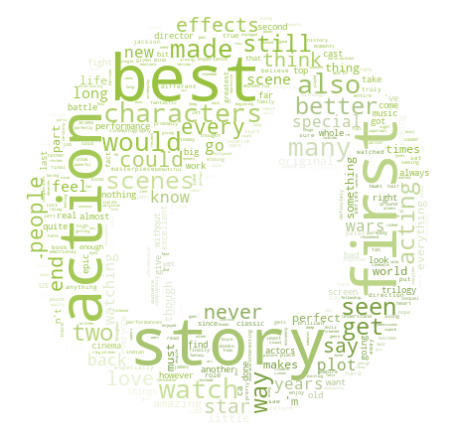

In [142]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from os import path, getcwd
d = getcwd()
mask = np.array(Image.open(path.join(d, "good.png")))
wc = WordCloud(background_color="white", max_words=5000, mask=mask,
               max_font_size=100, random_state=42)
wc.generate_from_frequencies(frequencies=df_wordfreq)
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[8,8])
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()

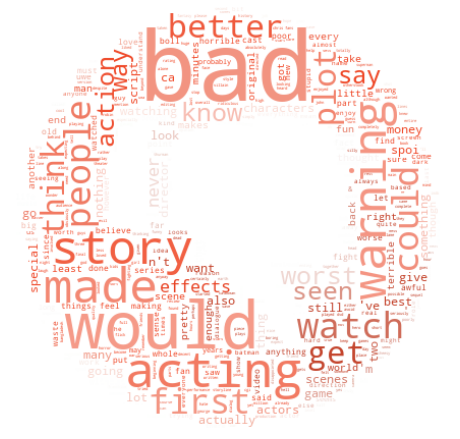

In [143]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from os import path, getcwd
d = getcwd()
mask = np.array(Image.open(path.join(d, "bad.png")))
wc = WordCloud(background_color="white", max_words=5000, mask=mask,
               max_font_size=100, random_state=42)
wc.generate_from_frequencies(frequencies=df_wordfreq2)
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[8,8])
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()

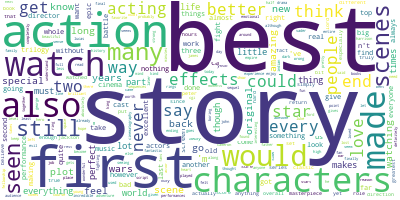

In [126]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate_from_frequencies(frequencies=df_wordfreq)
wordcloud.to_image()

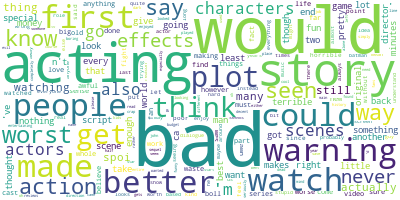

In [112]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate_from_frequencies(frequencies=df_wordfreq2)
wordcloud.to_image()